In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torcheeg.model_selection import KFold, train_test_split

In [2]:
from argparse import Namespace

args = {
    'dataset': 'bciciv2a',
    'model': 'eegnet',
    'attack': 'pgd',
    'fold': 0,
    'seed': 42,
}
args = Namespace(**args)

from data.load import *
dataset_dict = {
    'seediv': load_seediv,
    'm3cv': load_m3cv,
    'bciciv2a': load_bciciv2a,
    'thubenchmark': load_thubenchmark
}
dataset, info = dataset_dict[args.dataset]()

[2025-10-22 12:21:17] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./cached_data/bciciv2a_EA.


In [3]:
# load clean data and labels
cv = KFold(n_splits=5, shuffle=True, random_state=args.seed, split_path=f'./cached_data/{args.dataset}_split/kfold_split')
for fold, (train_dataset, test_dataset) in enumerate(cv.split(dataset)):
    if fold != args.fold:
        continue
    val_dataset, test_dataset = train_test_split(test_dataset, shuffle=True, test_size=0.5, random_state=args.seed, split_path=f'./cached_data/{args.dataset}_split/test_val_split_{fold}')
    print(f"Sample num in test set: {len(test_dataset)}")
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    clean_data = []
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        clean_data.append(inputs)
    clean_data = torch.cat(clean_data, dim=0)
    clean_labels = targets.numpy()

# load adversarial examples and labels
file_path = f'ad_data/{args.dataset}_{args.model}_{args.attack}_{args.seed}_fold{args.fold}.pth'
(adv_data, adv_labels) = torch.load(file_path)
print(adv_data.shape, adv_labels.shape)

[2025-10-22 12:21:17] INFO (torcheeg/MainThread) 📊 | Detected existing split of train and test set, use existing split from ./cached_data/bciciv2a_split/kfold_split.
[2025-10-22 12:21:17] INFO (torcheeg/MainThread) 💡 | If the dataset is re-generated, you need to re-generate the split of the dataset instead of using the previous split.
[2025-10-22 12:21:17] INFO (torcheeg/MainThread) 📊 | Detected existing split of train and test set, use existing split from ./cached_data/bciciv2a_split/test_val_split_0.
[2025-10-22 12:21:17] INFO (torcheeg/MainThread) 💡 | If the dataset is re-generated, you need to re-generate the split of the dataset instead of using the previous split.


Sample num in test set: 519
torch.Size([519, 1, 22, 1750]) torch.Size([519])


/tmp/ipykernel_164259/3570371730.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (adv_data, adv_labels) = torch.load(file_path)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_eeg(
    data,
    sfreq=None,
    ch_names=None,
    color=None,
    title=None,
    figsize=None,
    linewidth=0.8,
    grid=False,
    save_path=None,
):
    data = np.asarray(data)
    n_channels, n_times = data.shape

    if sfreq is not None and sfreq > 0:
        t = np.arange(n_times) / float(sfreq)
    else:
        t = np.arange(n_times)

    if ch_names is None:
        ch_names = [f"Ch{i}" for i in range(n_channels)]

    if figsize is None:
        figsize = (12, max(0.5 * n_channels, 4))

    fig, axes = plt.subplots(n_channels, 1, sharex=True, figsize=figsize, gridspec_kw={'hspace': 0.0})
    if n_channels == 1:
        axes = [axes]

    for i in range(n_channels):
        ax = axes[i]
        y = data[i]
        y_min, y_max = float(np.nanmin(y)), float(np.nanmax(y))
        pad = 0.05 * (y_max - y_min if y_max != y_min else abs(y_min) + 1e-9)
        ax.set_ylim(y_min - pad, y_max + pad)
        ax.plot(t, y, color=color, linewidth=linewidth)
        ax.set_ylabel(ch_names[i])

        # 取消y 轴刻度
        # ax.tick_params(axis='y', which='both', left=False, labelleft=False)

        # 隐藏所有坐标轴、刻度、边框
        if i == 0:
            # 第一个子图：隐藏 bottom 轴
            ax.spines['bottom'].set_visible(False)
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        elif i == n_channels - 1:
            # 最后一个子图：隐藏 top 轴
            ax.spines['top'].set_visible(False)
            ax.tick_params(axis='x', which='both', top=False, labeltop=False)
        else:
            # 中间子图：隐藏 top 和 bottom 轴
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.tick_params(axis='x', which='both', top=False, bottom=False, labelbottom=False)
        if grid:
            ax.grid(False)

    if title:
        fig.suptitle(title, y=0.995, fontsize=12)

    # plt.subplots_adjust(hspace=0.05, top=0.95)

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close(fig)

    # return fig, axes

def plot_double_eeg(
    data1,
    data2,
    sfreq=None,
    ch_names=None,
    color1=None,
    color2=None,
    title=None,
    figsize=None,
    linewidth=0.8,
    grid=False,
    save_path=None,
):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    n_channels, n_times = data1.shape

    if sfreq is not None and sfreq > 0:
        t = np.arange(n_times) / float(sfreq)
    else:
        t = np.arange(n_times)

    if ch_names is None:
        ch_names = [f"Ch{i}" for i in range(n_channels)]

    if figsize is None:
        figsize = (12, max(0.5 * n_channels, 4))

    fig, axes = plt.subplots(n_channels, 1, sharex=True, figsize=figsize, gridspec_kw={'hspace': 0.0})
    if n_channels == 1:
        axes = [axes]

    for i in range(n_channels):
        ax = axes[i]
        y1 = data1[i]
        y2 = data2[i]
        y1_min, y1_max = float(np.nanmin(y1)), float(np.nanmax(y1))
        y2_min, y2_max = float(np.nanmin(y2)), float(np.nanmax(y2))
        y_min = min(y1_min, y2_min)
        y_max = max(y1_max, y2_max)
        pad = 0.05 * (y_max - y_min if y_max != y_min else abs(y_min) + 1e-9)
        ax.set_ylim(y_min - pad, y_max + pad)
        ax.plot(t, y1, color=color1, linewidth=linewidth)
        ax.plot(t, y2, color=color2, linewidth=linewidth)
        ax.set_ylabel(ch_names[i])

        # 取消y 轴刻度
        # ax.tick_params(axis='y', which='both', left=False, labelleft=False)

        # 隐藏所有坐标轴、刻度、边框
        if i == 0:
            # 第一个子图：隐藏 bottom 轴
            ax.spines['bottom'].set_visible(False)
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        elif i == n_channels - 1:
            # 最后一个子图：隐藏 top 轴
            ax.spines['top'].set_visible(False)
            ax.tick_params(axis='x', which='both', top=False, labeltop=False)
        else:
            # 中间子图：隐藏 top 和 bottom 轴
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.tick_params(axis='x', which='both', top=False, bottom=False, labelbottom=False)
        if grid:
            ax.grid(False)

    if title:
        fig.suptitle(title, y=0.995, fontsize=12)

    # plt.subplots_adjust(hspace=0.05, top=0.95)

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close(fig)

    # return fig, axes

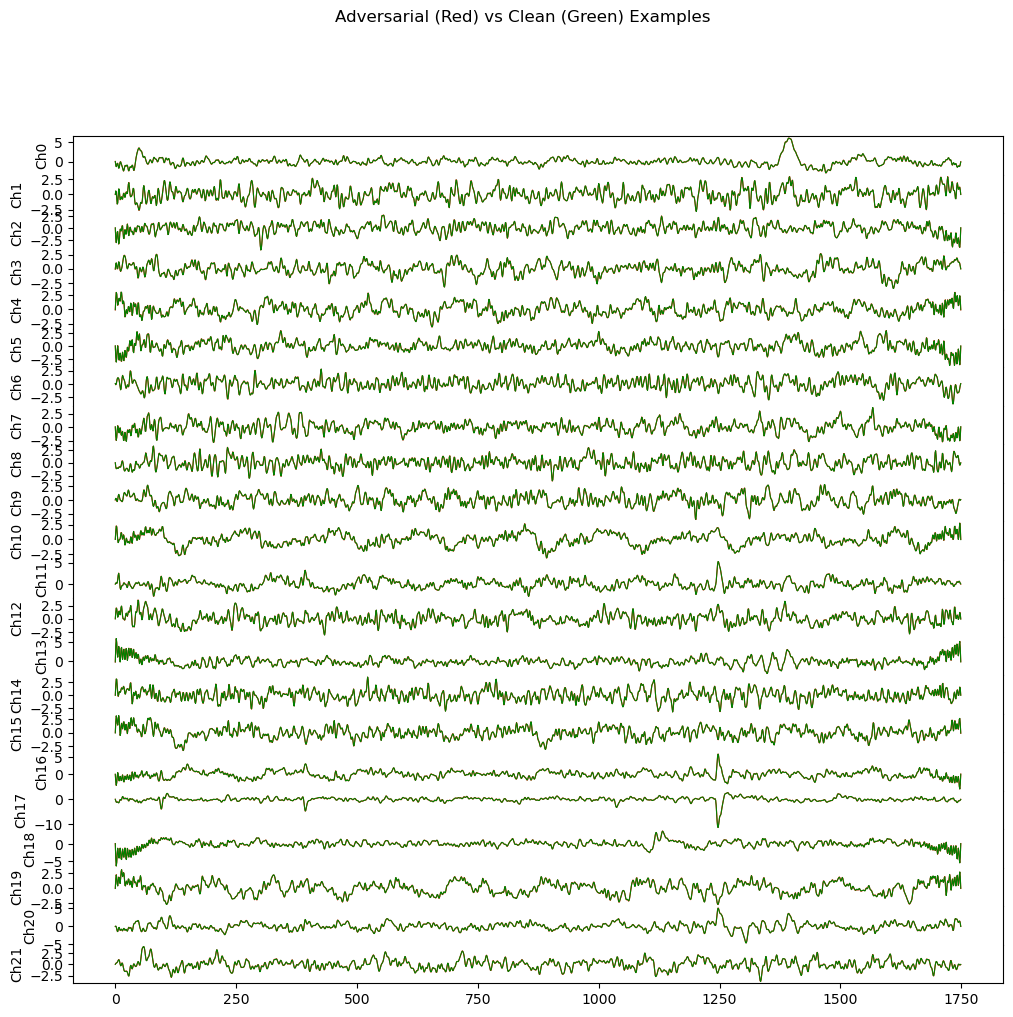

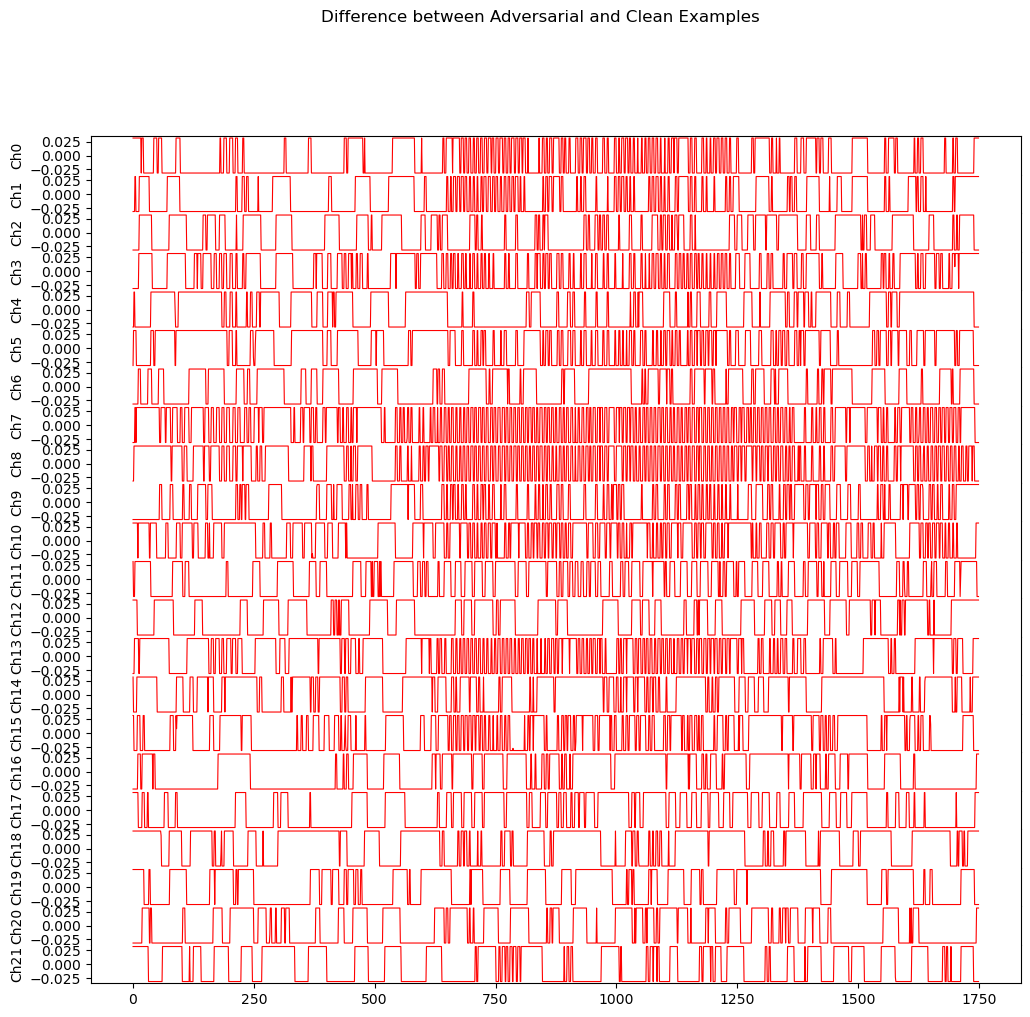

In [5]:
idx = 2
# plot_eeg(adv_data[idx].numpy().squeeze(), color='r', title=f'Adversarial Example - True Label: {clean_labels[idx]}, Adversarial Label: {adv_labels[idx]}')
# plot_eeg(clean_data[idx].numpy().squeeze(), color='g', title=f'Clean Example - True Label: {clean_labels[idx]}')
plot_double_eeg(adv_data[idx].numpy().squeeze(), clean_data[idx].numpy().squeeze(), color1='r', color2='g', title=f'Adversarial (Red) vs Clean (Green) Examples')
plot_eeg(adv_data[idx].numpy().squeeze()-clean_data[idx].numpy().squeeze(), color='r', title=f'Difference between Adversarial and Clean Examples')

In [6]:
# 可视化像素的分布
def visualize_distributions(clean_img: torch.Tensor, adv_img: torch.Tensor):
    """
    可视化干净图像、对抗图像及对抗扰动的像素值分布。
    
    参数:
      clean_img: 干净图像, 形状 [C, H, W], 通常数值范围在 [0, 1] 或 [0, 255]
      adv_img:   对抗图像, 形状 [C, H, W], 与 clean_img 相同
    """
    # 将图像移动到 CPU，并拉平成一维数组
    clean_np = clean_img.ravel()
    adv_np   = adv_img.ravel()

    # 计算对抗扰动
    perturb_np = adv_np - clean_np

    # 设置绘图窗口
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # 1. 干净图像像素分布
    axs[0].hist(clean_np, bins=100, color='blue', alpha=0.7)
    axs[0].set_title('Clean Image Distribution')
    axs[0].set_xlabel('Pixel Intensity')
    axs[0].set_ylabel('Count')

    # 2. 对抗图像像素分布
    axs[1].hist(adv_np, bins=100, color='red', alpha=0.7)
    axs[1].set_title('Adversarial Image Distribution')
    axs[1].set_xlabel('Pixel Intensity')
    axs[1].set_ylabel('Count')

    # 3. 对抗扰动像素分布
    #   如果图像值在 [0,1]，扰动通常会在一个较小范围内；可视化时可根据需要调整 bins 或 xlim
    axs[2].hist(perturb_np, bins=100, color='green', alpha=0.7)
    axs[2].set_title('Perturbation Distribution')
    axs[2].set_xlabel('Pixel Difference')
    axs[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# 计算图像的奇异值
def compute_svd(img):
    # # 将 PyTorch Tensor 转成 PIL Image，再转为灰度图
    # img_pil = transforms.ToPILImage()(img).convert('L')
    
    # # 转为 numpy 数组并做 SVD
    # img_gray = np.array(img_pil, dtype=float)  # shape: [32, 32]
    # print(img_gray.shape, img_gray.max(), img_gray.min())
    # U, s, Vt = np.linalg.svd(img_gray, full_matrices=False)

    img_numpy = img.numpy()
    img_channel1 = img_numpy[0]

    # 计算 SVD
    U1, s1, Vt1 = np.linalg.svd(img_channel1, full_matrices=False)

    return [s1]

# 可视化奇异值
def plot_svd(s, name):
    # # 设置绘图窗口
    # fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    # axs[0].plot(s[0][:], 'o-')
    # axs[0].set_title('Singular Value of Channel 1')
    # axs[0].set_xlabel('Index')
    # axs[0].set_ylabel('Singular Value')

    plt.plot(s[0][:], 'o-')
    plt.title('Singular Value of Channel 1')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')

    plt.tight_layout()
    plt.show()

    # plt.plot(s[:], 'o-')
    # plt.title(f"SVD on {name}")
    # plt.xlabel("Index")
    # plt.ylabel("Singular Value")
    # plt.show()


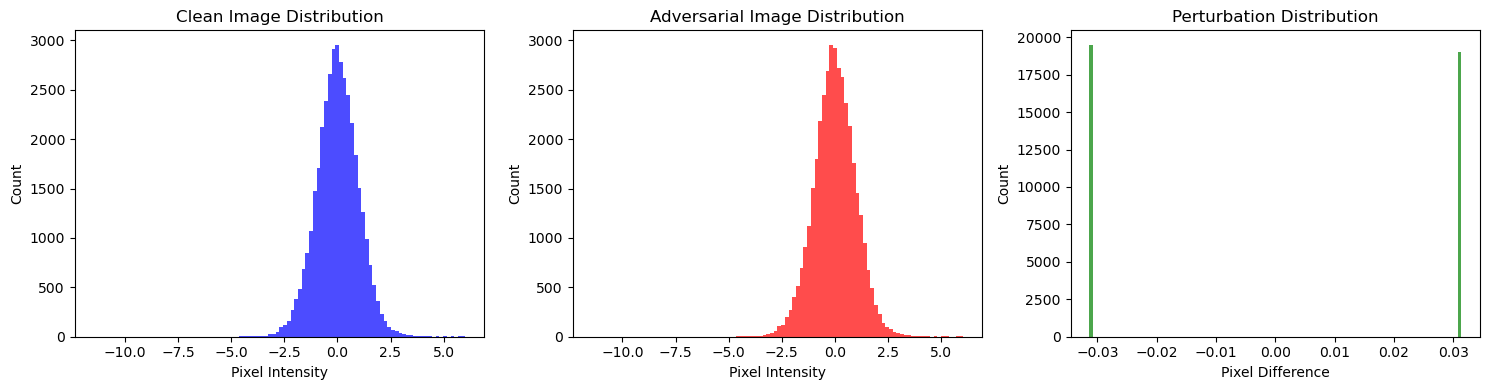

torch.Size([1, 22, 1750]) torch.Size([1, 22, 1750])


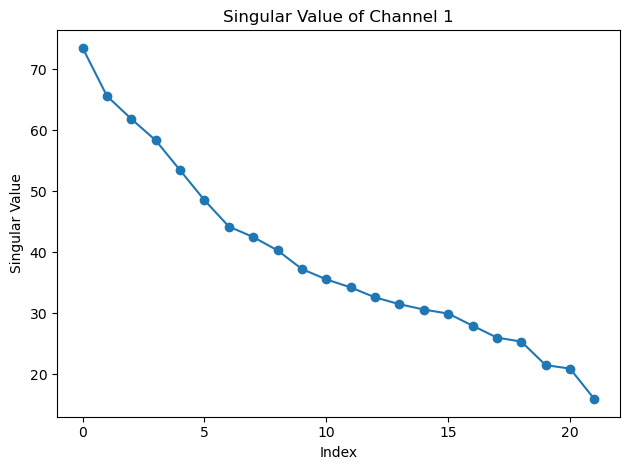

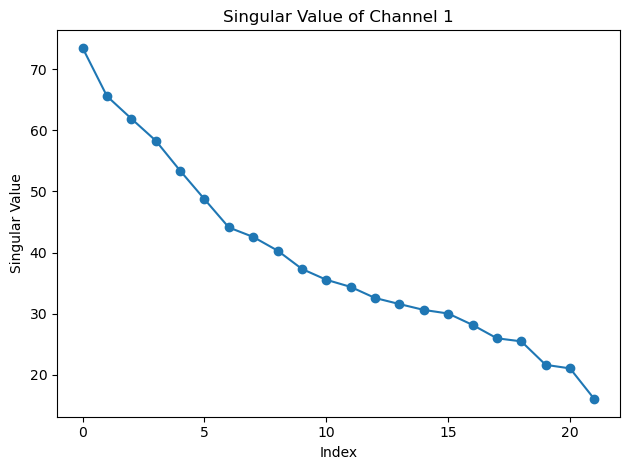

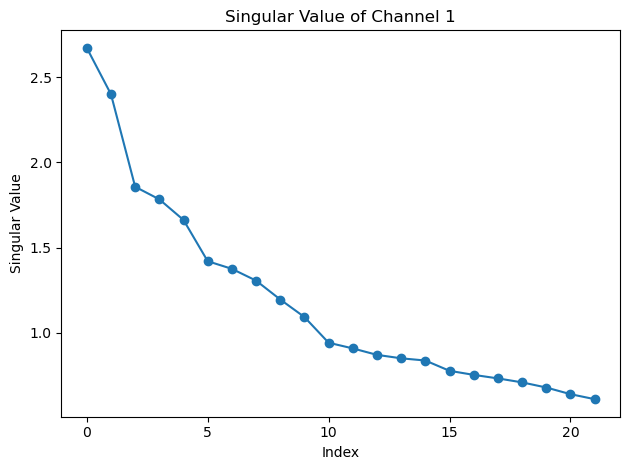

In [7]:
visualize_distributions(clean_data[idx], adv_data[idx])
print(clean_data[idx].shape, adv_data[idx].shape)

svd_vals = compute_svd(clean_data[idx])
plot_svd(svd_vals, 'Clean Image')

svd_vals = compute_svd(adv_data[idx])
plot_svd(svd_vals, 'Adversarial Image')

svd_vals = compute_svd(adv_data[idx]-clean_data[idx])
plot_svd(svd_vals, 'Adversarial Perturbation')